In [1]:
import os
import numpy as np
import pandas
import ast
from tqdm import tqdm
import json
import pandas as pd
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import re

In [2]:
with open("finished_reviews.txt",'r') as fr:
    finished_reviews = ast.literal_eval("[" + fr.readline() + "]")

e_f = []
with open("allrecipes-recipes.json") as f:
    for jsonOb in tqdm(f):
        recipesDict = json.loads(jsonOb)
        oldUrl = recipesDict["url"]
        title = recipesDict["title"]
        e_f.append((oldUrl,title))

225602it [00:03, 58261.40it/s]


In [3]:
tracker = 0
def update_tracker():
    global tracker
    tracker += 1
    return tracker - 1
people_to_ids = defaultdict(lambda : update_tracker())
full_line = True
reviews = []
with open("test.txt") as f:
    while (t:=f.readline()):
        parts = t.split(";")
        if full_line: # True if last line is concluded, false if we are at inner line
            
            people_to_ids[parts[1]]

            r = re.match(".*\; \d$", t)
            full_line = not r is None
            if full_line:
                reviews.append([int(parts[0]), people_to_ids[parts[1]],parts[2],int(parts[-1].replace("\n",""))])
            else:
                reviews.append([int(parts[0]), people_to_ids[parts[1]],parts[2],-1])
        else:
            r = re.match(".*\; \d$", t)
            full_line = not r is None
            if full_line:
                reviews[-1][2] = reviews[-1][2] + parts[0]
                reviews[-1][-1] = int(parts[-1].replace("\n",""))
            else:
                reviews[-1][2] = reviews[-1][2] + t            

In [4]:
r_df = pd.DataFrame(reviews)
print(len(r_df), "number of reviews initially")
r_df.columns = ['itemID', 'userID', 'text', 'rating']
r_df = r_df[r_df['userID'] != people_to_ids[' Allrecipes Member']]
print(len(r_df), "number of reviews after removing default name")
kept_users = set([k for k,v in dict(Counter(r_df['userID'])).items() if v > 150])
kept_items = set([k for k,v in dict(Counter(r_df['itemID'])).items() if v > 150])
r_df = r_df[(r_df['userID'].isin(kept_users)) & (r_df['itemID'].isin(kept_items))]
kept_users = set([k for k,v in dict(Counter(r_df['userID'])).items() if v > 150])
kept_items = set([k for k,v in dict(Counter(r_df['itemID'])).items() if v > 150])
r_df = r_df[(r_df['userID'].isin(kept_users)) & (r_df['itemID'].isin(kept_items))]

print(len(r_df), "number of reviews after removing users and items with less than 50 reviews")
print(len(pd.unique(r_df['userID'])), "number of unique users")
print(len(pd.unique(r_df['itemID'])), "number of unique items")

2361583 number of reviews initially
2192374 number of reviews after removing default name
82975 number of reviews after removing users and items with less than 50 reviews
496 number of unique users
310 number of unique items


In [5]:
#find the user with minimum and maximum review count

d = [(k,v) for k,v in dict(Counter(r_df['itemID'])).items()]
print(sorted(d, key = lambda x: x[1])[0])
print(sorted(d, key = lambda x: x[1])[-1])

(11616, 115)
(34, 1331)


In [6]:
#find the distribution of reviews given

Counter(r_df['rating'])

Counter({5: 62507, 4: 13936, 3: 3917, 2: 1506, 1: 1109})

In [7]:
#save df to csv
r_df.to_csv("data/new_user_recipe.csv")

In [8]:
#print some of the highest review counts
sorted([(k,v) for k,v in dict(Counter(r_df['userID'])).items()], key = lambda x: x[1])[-10:]

[(1119, 730),
 (1986, 774),
 (260, 776),
 (2589, 781),
 (4943, 820),
 (1574, 828),
 (1727, 847),
 (847, 902),
 (451, 1018),
 (1196, 1107)]

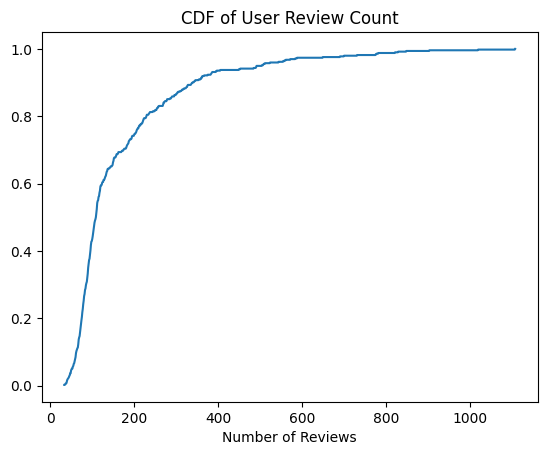

In [11]:
count, bins_count = np.histogram(list(Counter(r_df['userID']).values()), bins=1000)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.title("CDF of User Review Count")
plt.xlabel("Number of Reviews")
plt.plot(bins_count[1:], cdf, label="CDF")